# Summary of Imaging Analyses Results

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text
import py3Dmol
import polars as pl
from Bio.PDB import PDBParser
from sklearn.cluster import AgglomerativeClustering
import sys
import glob

sns.set_style(style='white')
sys.path.append("../../..")
from utils import *

In [4]:
METADATA_INPUT = "../../../../1_allele_collection/1_inputs"
FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"
GFP_MISLOCAL_FEAT_LENIENT = "Altered_95th_perc_both_batches_GFP"
# Original cell imaging profiles
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}
BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

In [18]:
cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
)
prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
)
auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
auroc_summary_df = auroc_summary_df.with_columns(
    [pl.col(f"Altered_95th_perc_{feat}").cast(pl.Boolean, strict=False).alias(f"Altered_95th_perc_{feat}") for feat in FEAT_SETS]
)
imaging_summary = cell_count_summary.join(
    prot_abund_summary,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).join(
    auroc_summary_df,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).with_columns(
    pl.lit(True).alias("image_assayed"),
).filter(
    pl.col("Gene")!="CCM2"
).rename(
    dict(zip([f"Altered_95th_perc_{feat}" for feat in FEAT_SETS], 
            [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]))
)

clin_var_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv",  ##
                          separator="\t", infer_schema_length=1000000
).with_columns(
    pl.col("gene_variant").alias("gene_allele"),
)

imaging_summary_clinvar = imaging_summary.filter(
    ~pl.col("gene_allele").str.contains("CCM2"),
    pl.col("Metadata_Bio_Batch").is_in(["2025_01_Batch_13-14",])
).join(
    clin_var_df.select(["gene_allele"]+[c for c in clin_var_df.columns if c not in imaging_summary.columns]).unique("gene_allele"),
    on=["gene_allele"],
    how="inner"
).with_columns(
    pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
)
# with pl.Config(set_tbl_rows=30):
#     display(
#         imaging_summary.filter(
#             ~pl.col("gene_allele").is_in(imaging_summary_clinvar["gene_allele"].unique())
#         )
#     )

In [32]:
imaging_summary_clinvar[[f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]]#.shape

Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph
bool,bool,bool,bool,bool
true,true,true,true,true
false,false,false,false,false
false,false,false,false,false
false,false,false,false,false
false,false,false,false,false
…,…,…,…,…
false,false,false,false,false
false,false,false,false,false
false,false,false,false,false


## 1. Import from 1% paper output

In [8]:
# clin_var_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv",  ##
#                           separator="\t", infer_schema_length=1000000
# ).with_columns(
#     pl.col("gene_variant").alias("gene_allele"),
# )
# cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
#     {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
# )
# prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
#     {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
# )
# auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
# imaging_summary = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/imaging_analyses_summary_clinvar.tsv",
#                              separator="\t", infer_schema_length=10000)

In [9]:
# imaging_summary = imaging_summary.with_columns(
#     pl.lit(True).alias("image_assayed")
# )
# imaging_summary_clinvar = imaging_summary.filter(
#     ~pl.col("gene_allele").str.contains("CCM2"),
#     pl.col("Metadata_Bio_Batch").is_in(["2025_01_Batch_13-14",])
# ).with_columns(
#     pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
# ).join(
#     clin_var_df.select(["gene_allele"]+[c for c in clin_var_df.columns if c not in imaging_summary.columns]).unique("gene_allele"),
#     on=["gene_allele"],
#     how="inner"
# )
# imaging_summary_clinvar = imaging_summary_clinvar.with_columns(
#     pl.col("Gene").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("Gene"),
#     pl.col("gene_allele").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("gene_variant") 
# )
# # imaging_summary_clinvar

# imaging_summary_clinvar_hits = imaging_summary_clinvar.filter(
#     pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1
# )
# # imaging_summary_clinvar_hits.shape

In [18]:
# imaging_summary_clinvar.write_csv("../../3_outputs/2_results_summary/imaging_analyses_summary_clinvar.tsv", separator="\t")
# imaging_summary_clinvar.write_csv("../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t")

## 2. Plots

In [12]:
df = imaging_summary_clinvar.to_pandas() ## drop_nulls("clinvar_clnsig_clean").
# Count category frequencies
# Sort categories if you want specific order
category_order = sorted(df["clinvar_clnsig_clean"].unique())

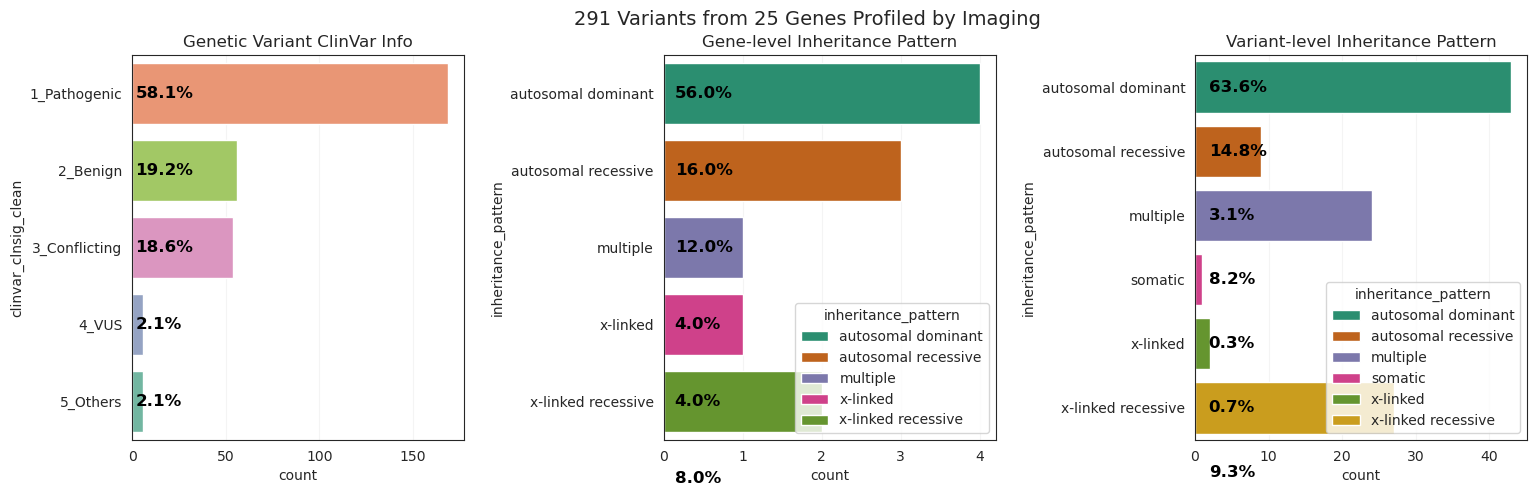

In [13]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
plot_cat_count_perc(
    imaging_summary_clinvar,
    "clinvar_clnsig_clean",
    title="ClinVar",
    ax=axes[0],
    palette=palette_dict["clinvar_clnsig_clean"]
)
axes[0].set_title("Genetic Variant ClinVar Info")

plot_cat_count_perc(
    imaging_summary_clinvar.unique("symbol"),
    "inheritance_pattern",
    title="Inheritance",
    ax=axes[1],
)
axes[1].set_title("Gene-level Inheritance Pattern")

plot_cat_count_perc(
    imaging_summary_clinvar,
    "inheritance_pattern",
    title="Inheritance",
    ax=axes[2],
)
axes[2].set_title("Variant-level Inheritance Pattern")

plt.suptitle(f"{imaging_summary_clinvar.unique('gene_allele').shape[0]} Variants from {imaging_summary_clinvar.unique('symbol').shape[0]} Genes Profiled by Imaging", y=.97, fontsize=14)
plt.subplots_adjust(wspace=.6)
plt.show()

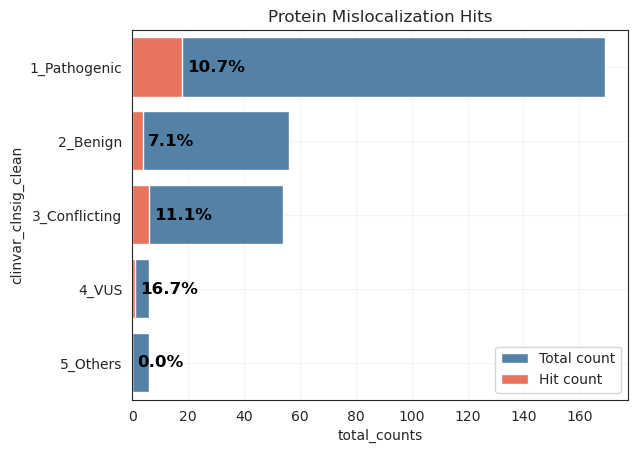

In [20]:
fig, ax = plt.subplots(1,1)
plot_assay_hit_by_category(imaging_summary_clinvar, "Altered_95th_perc_both_batches_GFP", "clinvar_clnsig_clean", f"Protein Mislocalization Hits", ax=ax)
plt.show()

<Figure size 640x480 with 0 Axes>

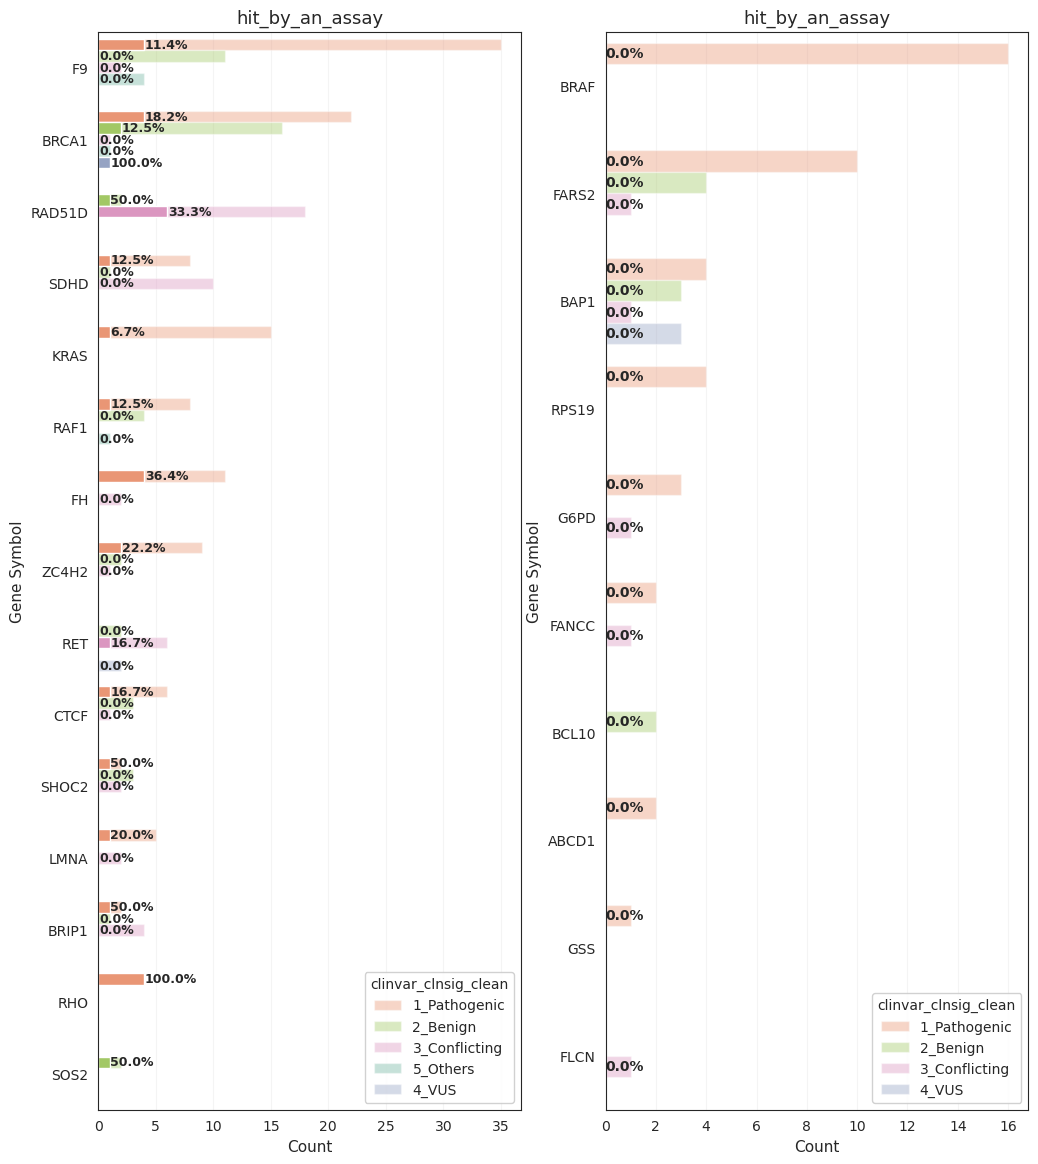

In [26]:
plt.clf()
fig, ax = plt.subplots(1,2,figsize=(12, 14))
plot_gene_level_summary(
    imaging_summary_clinvar.with_columns(
        (
            (pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1)
        ).alias("hit_by_an_assay"),
        pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
    ).filter(
        pl.col("Gene").is_in(imaging_summary_clinvar_hits["Gene"].unique())
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"],
    ax=ax[0]
)

_ = plot_gene_level_summary(
    imaging_summary_clinvar.with_columns(
        (
            (pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1)
        ).alias("hit_by_an_assay")
    ).filter(
        ~pl.col("Gene").is_in(imaging_summary_clinvar_hits["Gene"].unique())
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"],
    ax=ax[1]
)

In [27]:
hue_order = sorted(imaging_summary_clinvar.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
gene_order = imaging_summary_clinvar.unique("gene_variant").group_by("Gene").agg(
    pl.len()
).sort("len", descending=False)["Gene"]
auroc_cols = sorted([col for col in imaging_summary_clinvar.columns if col.startswith("AUROC_Mean") and not col.endswith("_right")])
alter_95th_cols = sorted([col for col in imaging_summary_clinvar.columns if col.startswith("Altered_95th_perc") and not col.endswith("_right")])

<Figure size 640x480 with 0 Axes>

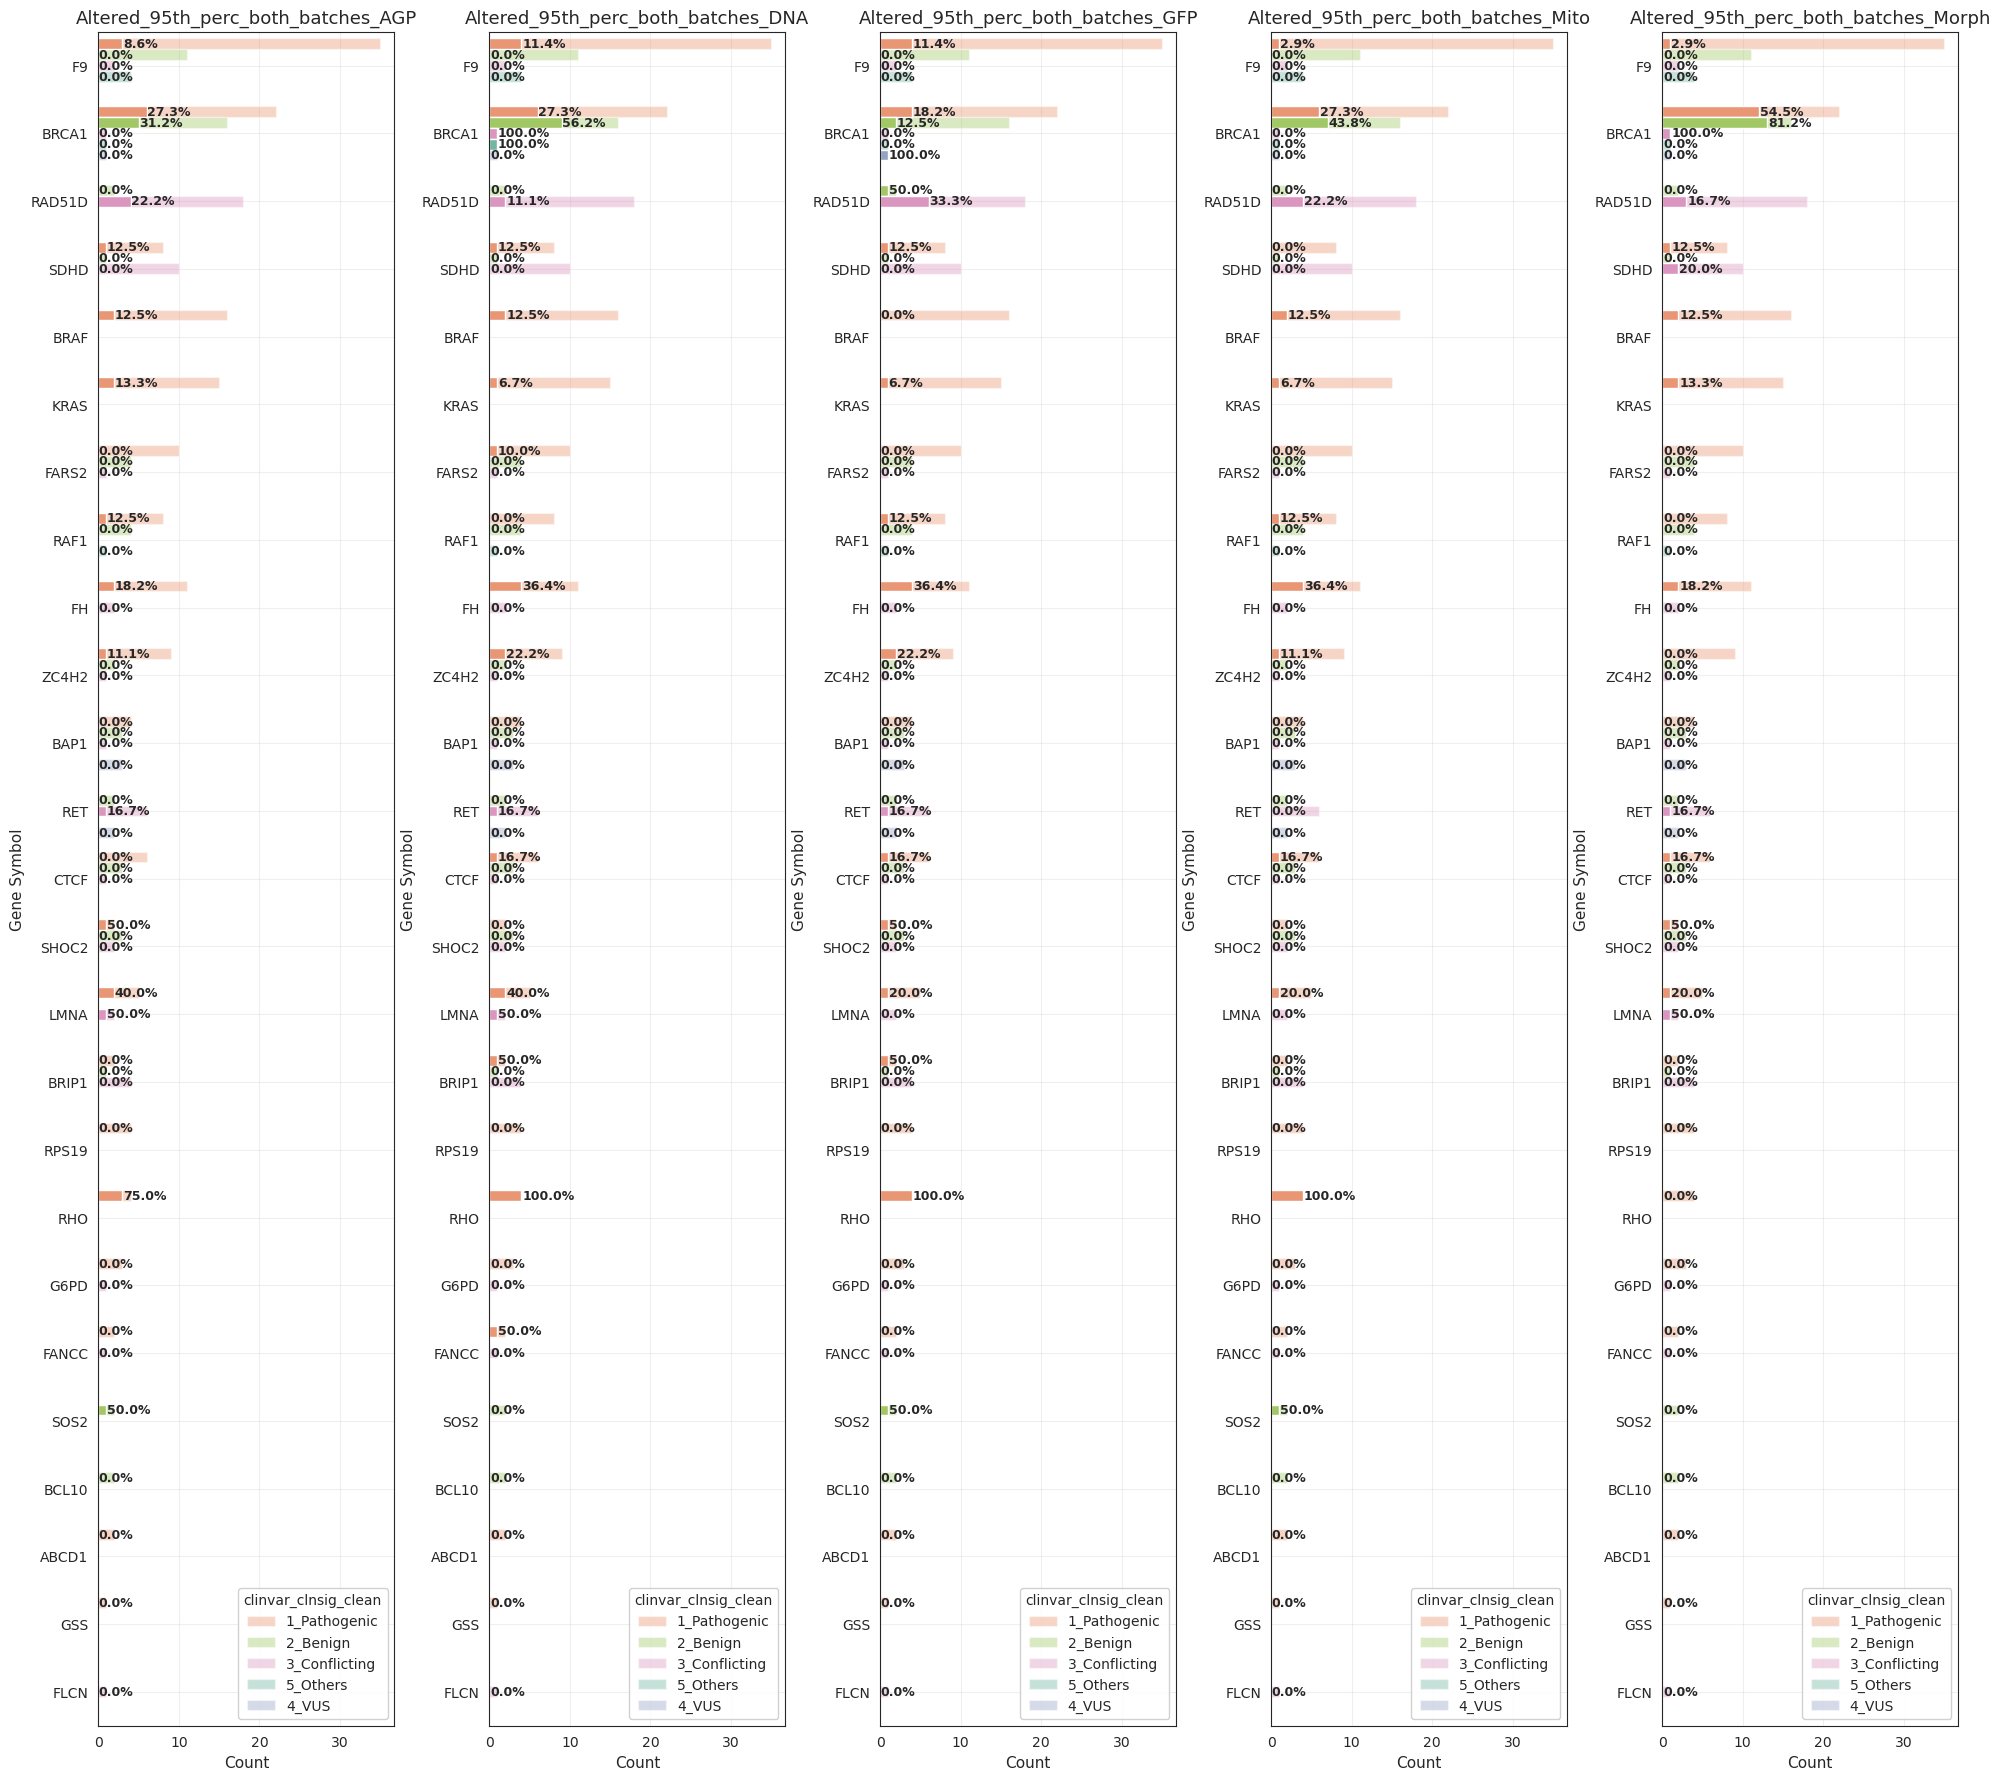

In [28]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 22))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary_clinvar.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), assay=col, ax=ax[i], palette=palette_dict["clinvar_clnsig_clean"]) ## gene_order=gene_order, hits_only=False,, col, col+"\n"
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

<Figure size 640x480 with 0 Axes>

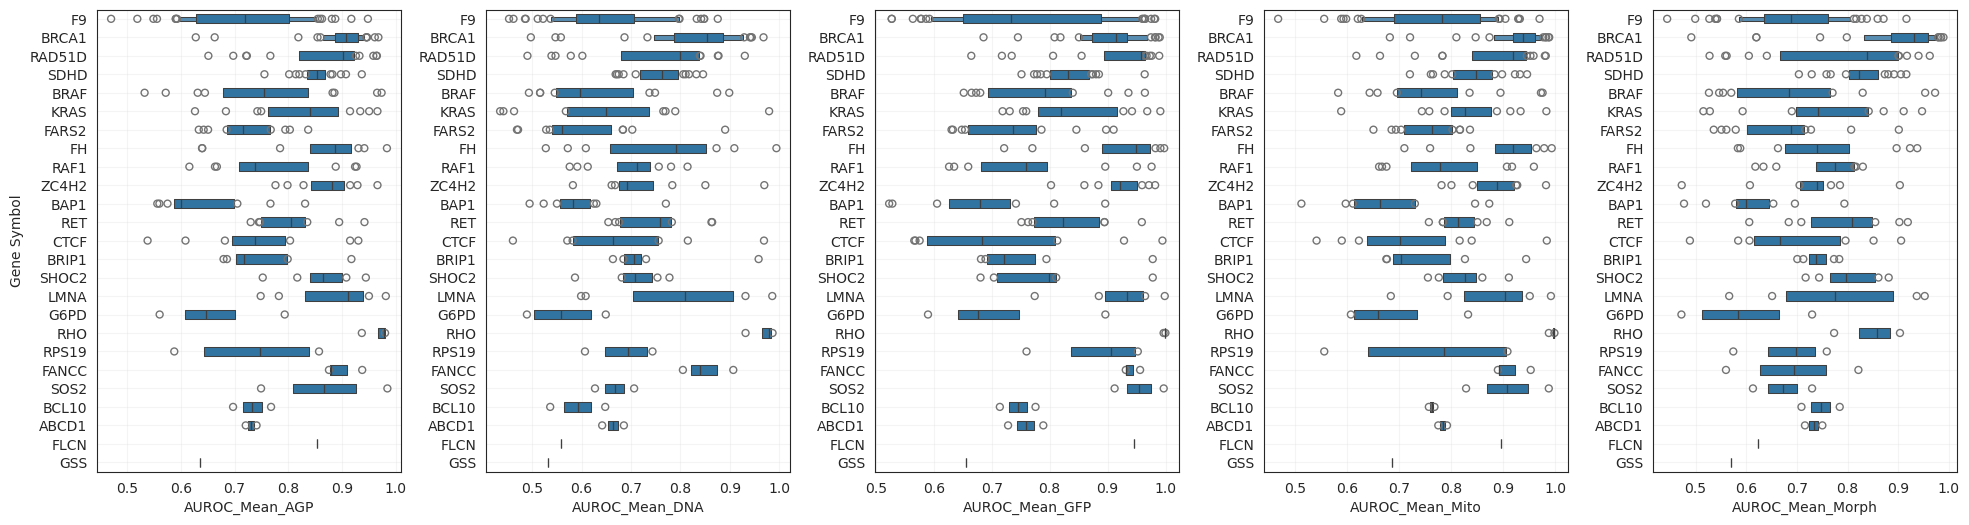

In [29]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 6))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary_clinvar.unique("gene_variant").to_pandas(), x=col, y="Gene", ax=ax[i], width=.5, 
                 order=gene_order[::-1])
    # ax.set_xlabel("AUROC_Mean_GFP")
    ax[i].set_ylabel("")
    ax[i].grid(alpha=0.2)
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

## 3. Pillar overlap

In [54]:
pillar_clinvar_df = pl.read_csv(
    "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes Pillar ALL:", pillar_clinvar_df.unique(subset="Gene").shape[0])
print("Number of unique genes Pillar SNP:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Filtered missense/SNP pillar dataset shape: (176277, 109)
Number of unique genes Pillar ALL: 40
Number of unique genes Pillar SNP: 40
Number of unique gene variants: 94200


In [52]:
imaging_summary_clinvar_pillar_snp_unpub_df = imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
).filter(
    pl.col("gene_allele")==pl.col("gene_variant_pp")
)
# .filter(
#     pl.col("Dataset").str.contains("_unpublished")
# )
imaging_summary_clinvar_pillar_snp_unpub_df.unique("gene_allele")

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_both_batches_Morph,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Classification by multifactorial model_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,bool,str,str,i64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""F9""","""F9_Phe395Ile""",-2.751249,0.028453,2.168774,0.066738,"""2025_01_Batch_13-14""",0.781915,0.712288,0.820742,0.819575,0.611101,0.5173,0.806238,0.929957,0.886326,0.706212,0.649607,0.759263,0.875349,0.85295,0.658657,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Phe395Ile""","""Phe395Ile""",true
"""F9""","""F9_Arg191Cys""",-3.11409,0.02074,4.191694,0.004077,"""2025_01_Batch_13-14""",0.829494,0.821665,0.904936,0.907162,0.798051,0.586891,0.755435,0.878836,0.826202,0.657345,0.708192,0.78855,0.891886,0.866682,0.727698,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Arg191Cys""","""Arg191Cys""",true
"""BAP1""","""BAP1_Thr93Ala""",-0.656766,0.532321,-1.82875,0.110147,"""2025_01_Batch_13-14""",0.62024,0.6362,0.751203,0.689209,0.615388,0.536089,0.56278,0.73238,0.635149,0.634138,0.578164,0.59949,0.741792,0.662179,0.624763,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""BAP1""",null,3760,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""BAP1_Thr93Ala""","""Thr93Ala""",true
"""RAD51D""","""RAD51D_Ala231Ser""",0.248881,0.810597,15.706225,0.000001,"""2025_01_Batch_13-14""",0.612421,0.794866,0.961714,0.779003,0.682607,0.881861,0.900984,0.960634,0.937064,0.843813,0.747141,0.847925,0.961174,0.858034,0.76321,false,false,true,false,false,0.0,0.

<Axes: xlabel='measurement_type', ylabel='AUROC'>

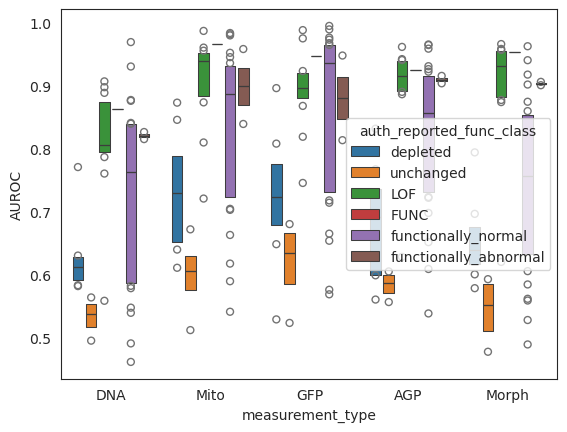

In [53]:
sns.boxenplot(
    data=imaging_summary_clinvar_pillar_snp_unpub_df.select([
        col for col in imaging_summary_clinvar_pillar_snp_unpub_df.columns 
        if imaging_summary_clinvar_pillar_snp_unpub_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2
)

In [55]:
# imaging_summary_clinvar.join(
#     pillar_clinvar_df,
#     left_on="gene_allele",
#     right_on="gene_variant",
#     suffix="_pp",
#     how="inner"
# ).unique("gene_allele")

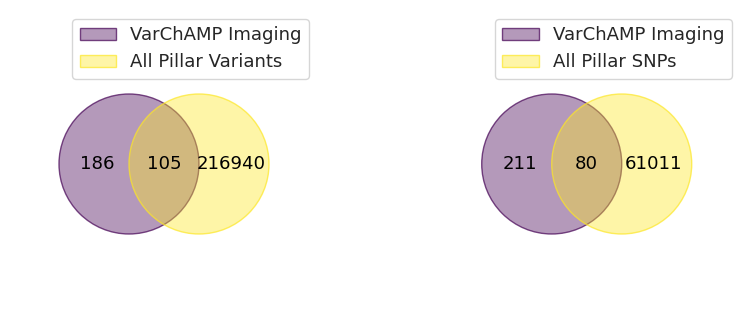

In [31]:
from venn import venn
img_pp_set = {
    'VarChAMP Imaging': set(imaging_summary_clinvar["gene_allele"].unique()),
    'All Pillar Variants': set(pillar_clinvar_df["gene_variant"].unique())
}
img_pp_snp_set = {
    'VarChAMP Imaging': set(imaging_summary_clinvar["gene_allele"].unique()),
    'All Pillar SNPs': set(pillar_clinvar_single_aa_df["gene_variant"].unique())
}
fig, axes = plt.subplots(1,2,figsize=(10,4))
venn(img_pp_set, ax=axes[0])
venn(img_pp_snp_set, ax=axes[1])
plt.show()

In [32]:
imaging_summary_clinvar_pp = imaging_summary_clinvar.join(
    pillar_clinvar_df.select(["gene_variant"]+[c for c in pillar_clinvar_df.columns if c not in imaging_summary_clinvar.columns]),
    left_on="gene_allele",
    right_on="gene_variant",
    how="inner",
    coalesce=True
)

<Figure size 640x480 with 0 Axes>

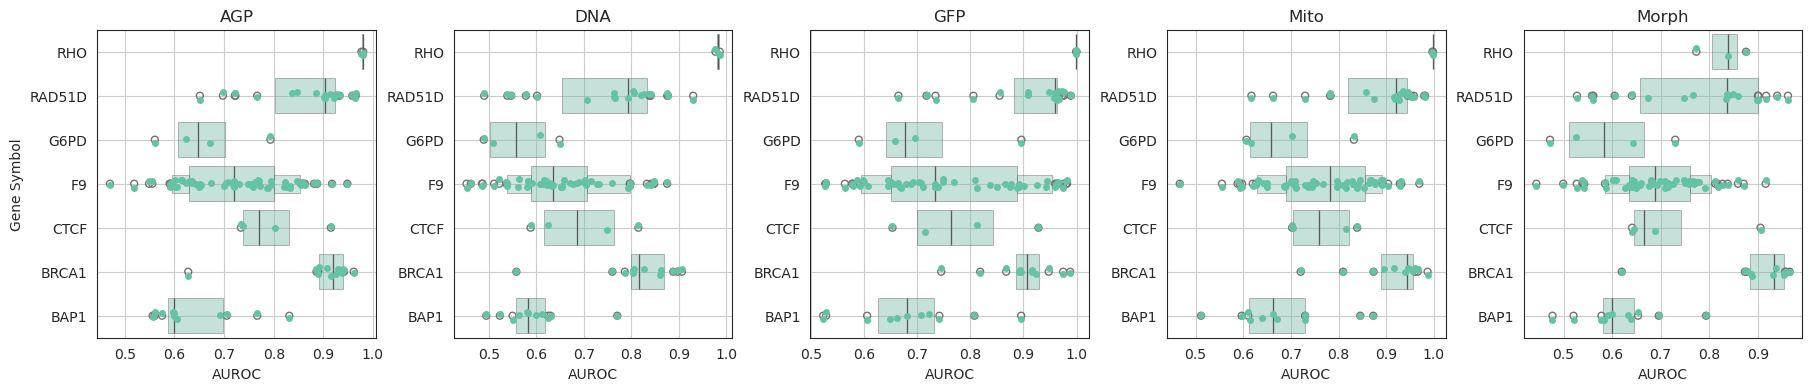

In [33]:
plt.clf()
gene_order_pillar = imaging_summary_clinvar_pp.sort("Gene").unique("Gene")["Gene"]
fig, ax = plt.subplots(1,5,figsize=(22, 4))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary_clinvar_pp.unique("gene_variant").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[0],
                  order=gene_order_pillar[::-1],
                  alpha=.4,
                  # gap=.2,
                x=col, y="Gene", ax=ax[i]) #, width=.5
    sns.stripplot(data=imaging_summary_clinvar_pp.unique("gene_variant").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[0],
                  order=gene_order_pillar[::-1],
                  # gap=.2,
                x=col, y="Gene", ax=ax[i]) #, width=.5
    
    ax[i].set_xlabel("AUROC")
    ax[i].set_ylabel("")
    ax[i].set_title(col.split("_")[-1])
    ax[i].grid()
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

<Figure size 640x480 with 0 Axes>

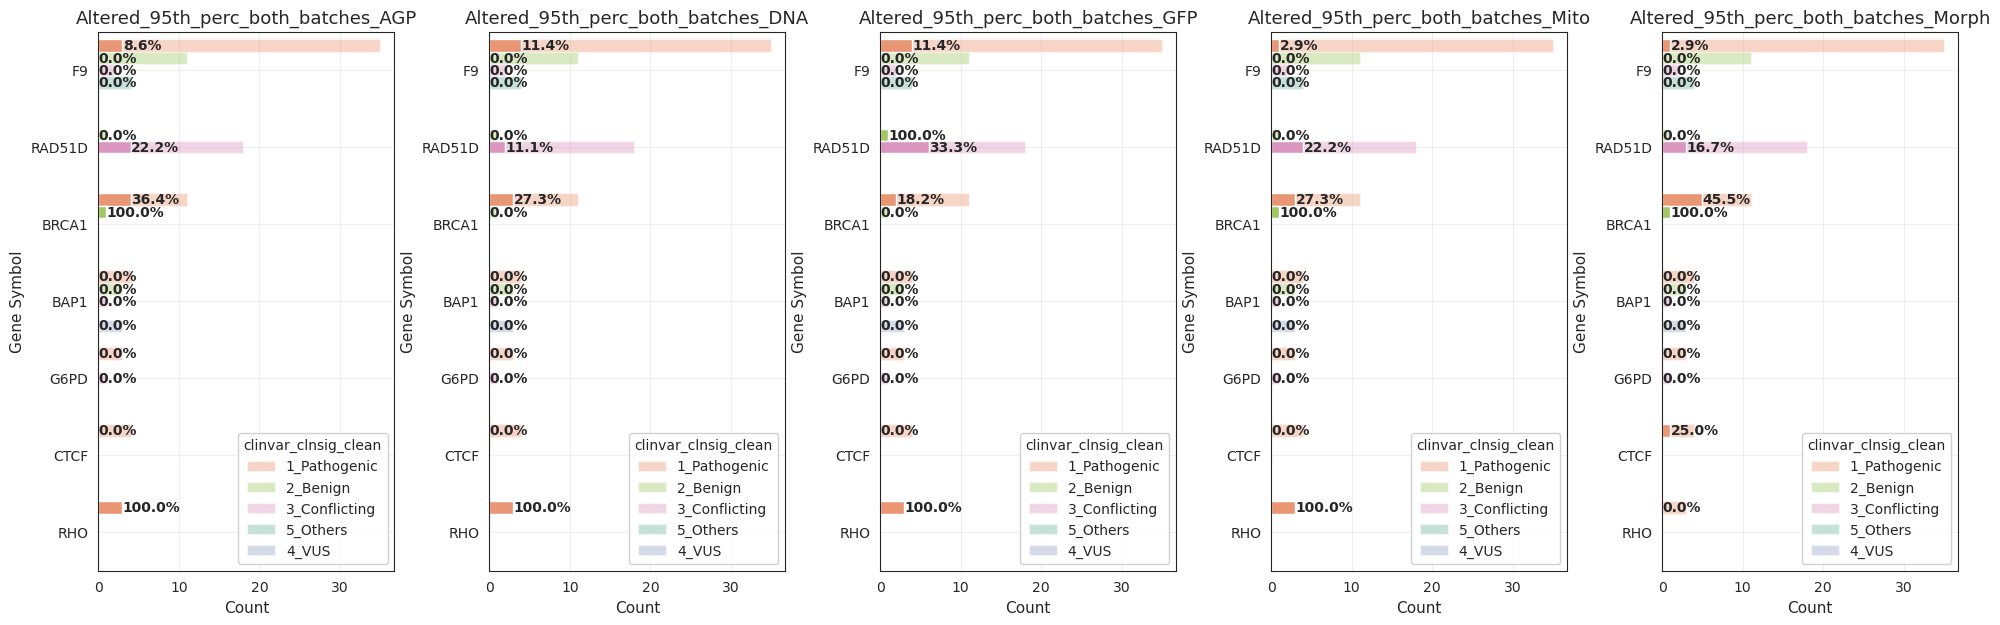

In [34]:
# plt.clf()
# fig, ax = plt.subplots(1,5,figsize=(20, 4))
# for i, col in enumerate(alter_95th_cols):
#     plot_gene_level_summary(scores.with_columns(
#         pl.col(col).cast(pl.Boolean).alias(col)
#     ), col, col+"\n", gene_order=gene_order_pillar, hits_only=False, ax=ax[i])

# # fig, ax = plt.subplots(1,1,figsize=(6,15))
# # plot_gene_level_summary(scores, "Altered_95th_perc_Morph", "Altered_95th_perc_Morph", hits_only=False, null_only=True, ax=ax)

# # fig, ax = plt.subplots(1,1,figsize=(6,4))
# # plot_gene_level_summary(func_scores, "dualipa_abund_change", "DUAL-IPA Abundance Change Pillar Variants", hits_only=False, ax=ax)
# plt.subplots_adjust(wspace=.32)
# plt.show()

plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 7))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary_clinvar_pp.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), assay=col, ax=ax[i], palette=palette_dict["clinvar_clnsig_clean"]) ## gene_order=gene_order, hits_only=False,, col, col+"\n"
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

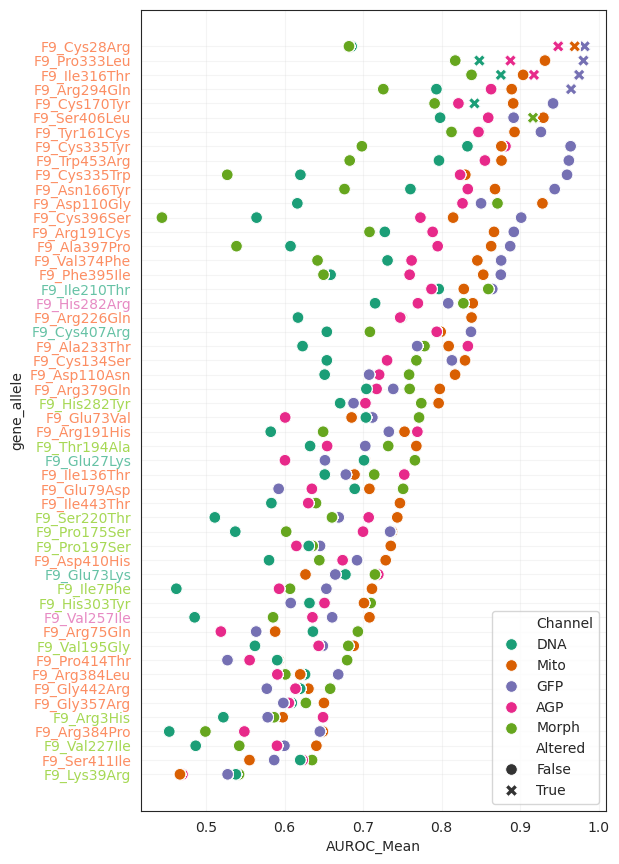

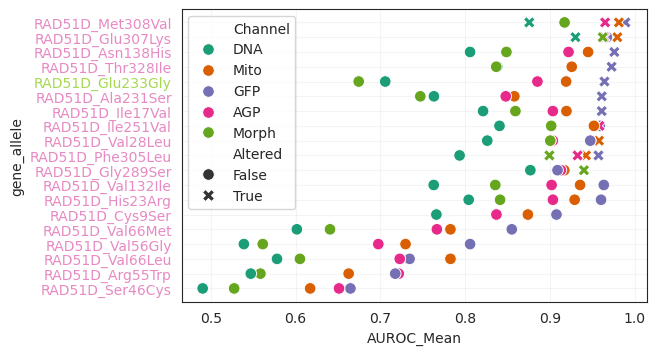

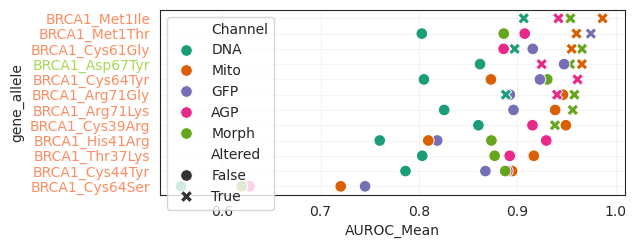

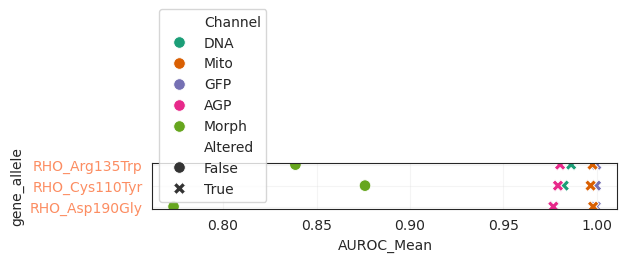

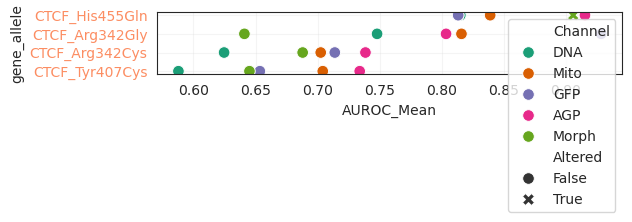

In [70]:
key_genes = ["F9", "RAD51D", "BRCA1", "RHO", "CTCF"]
for gene in key_genes:
    img_pp_gene = imaging_summary_clinvar_pp.filter(
        pl.col("Gene")==gene
    )
    long_df = pl.concat([
        img_pp_gene.filter(
            (pl.col("AUROC_Mean_GFP").is_not_null())
        ).with_columns(
            pl.any_horizontal([pl.col(f"Altered_95th_perc_both_batches_{col}")==1 for col in FEAT_SETS]).alias("hits"),
            # pl.concat_str([pl.col("gene_allele").str.split("_").list.get(-1), 
            #                pl.col("clinvar_clnsig_clean").str.split("_").list.get(-1)], separator="_").alias(f"{gene} Variant")
        ).select([
            pl.col("gene_allele"),
            pl.lit(cat).alias("Channel"),
            pl.col(f"Altered_95th_perc_both_batches_{cat}")
                .cast(pl.Boolean)
                .alias("Altered"),
            pl.col(f"AUROC_Mean_{cat}")
                .alias("AUROC_Mean"),
            "hits", "clinvar_clnsig_clean"  # Keep clinvar info
        ])
        for cat in FEAT_SETS
    ])
    
    fig, ax = plt.subplots(1,1, figsize=(6,img_pp_gene.unique("gene_allele").shape[0]*.2))
    sns.scatterplot(data=long_df.sort(["hits","AUROC_Mean"], descending=True).to_pandas(), 
                    y=f"gene_allele", x="AUROC_Mean", 
                    style="Altered", hue="Channel", ax=ax, s=70, palette="Dark2", hue_order=FEAT_SETS)
    
    # Create mapping from variant name to clinvar classification
    df_pandas = long_df.to_pandas()
    variant_to_clinvar = df_pandas.drop_duplicates(f"gene_allele").set_index(f"gene_allele")["clinvar_clnsig_clean"].to_dict()
    
    # Color the y-axis tick labels based on clinvar classification
    for tick in ax.get_yticklabels():
        variant_name = tick.get_text()
        clinvar_class = variant_to_clinvar.get(variant_name)
        if clinvar_class and clinvar_class in palette_dict["clinvar_clnsig_clean"]:
            tick.set_color(palette_dict["clinvar_clnsig_clean"][clinvar_class])
    ax.legend(ncol=1, frameon=True)
    ax.grid(alpha=.2)
    plt.show()

    # print(img_pp_gene.select(["gene_allele"]+[
    #     pl.col(col) for col in [c for c in img_pp_gene.columns if c in pillar_clinvar_df.columns]
    #     if not img_pp_gene[col].is_null().all()
    # ]))
    # print([
    #     pl.col(col) for col in [c for c in img_pp_gene.columns if c in pillar_clinvar_df.columns]
    #     if not img_pp_gene[col].is_null().all()
    # ])
    # gene_feat_df = norm_feat_gene.filter(
    #     pl.col("Metadata_gene_allele").str.contains(gene)
    # ).to_pandas().set_index("Metadata_gene_allele")
    # sns.clustermap(
    #     gene_feat_df.T,
    #     cmap="vlag"
    # )
    # break
    # gene_uniprot_id = get_uniprot_swissprot_id("F9")
    # print(f"UniProt Swiss‐Prot ID for {gene}:", {gene_uniprot_id} or "Not found")
    # af2_struc_pdb_dir = "/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4"
    # pdb_file = [pdb for pdb in glob.glob(f"{af2_struc_pdb_dir}/*.pdb.gz") if gene_uniprot_id in pdb][0]
    # pdb_file
    # break

In [72]:
rad51d_allele = imaging_summary_clinvar_pp.filter(
    pl.col("gene_variant").str.contains("RAD51D")
)

In [73]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
import requests
import glob
import gzip
import re
import os
import py3Dmol
from Bio.PDB import PDBParser
import requests
import gzip

def get_uniprot_swissprot_id(protein_name: str) -> str:
    """
    Query UniProt’s REST search API to find the reviewed (Swiss‐Prot) accession
    for a given human gene/protein name. Returns None if not found.
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    # Build a query that:
    #  - matches the gene name exactly (using “gene:”)
    #  - restricts to human (organism_id:9606)
    #  - restricts to reviewed (Swiss‐Prot) entries
    query = f"gene:{protein_name} AND organism_id:9606 AND reviewed:true"
    params = {
        "query": query,
        "fields": "accession",
        "format": "json",
        "size": 1,      # only need the top hit
    }
    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        results = data.get("results", [])
        if not results:
            return None
        return results[0]["primaryAccession"]
    except Exception:
        # If the request fails (e.g. no internet), return None
        return None

gene = "RAD51D"
gene_uniprot_id = get_uniprot_swissprot_id(gene)
print(f"UniProt Swiss‐Prot ID for {gene}:", {gene_uniprot_id} or "Not found")

af2_struc_pdb_dir = "/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4"

pdb_file = [pdb for pdb in glob.glob(f"{af2_struc_pdb_dir}/*.pdb.gz") if gene_uniprot_id in pdb][0]
pdb_file

# 1. Parse the structure
# 1) Open the .pdb.gz file with gzip.open in text/binary mode:
with gzip.open(pdb_file, "rt") as handle:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("rho", handle)

    # 3. Rewind and read the entire PDB text
    handle.seek(0)
    pdb_text = handle.read()

# 2. Build a map: residue_number → (x, y, z) of its Cα atom
ca_coords = {}
for model in structure:
    for chain in model:
        if chain.get_id() == "A":
            for residue in chain:
                resnum = residue.get_id()[1]
                # Only consider standard amino acids with a CA atom
                if 'CA' in residue:
                    atom_ca = residue['CA']
                    ca_coords[resnum] = atom_ca.get_coord()

# 2) List of variants in “RHO_AminoAcidResidueNumberNewAminoAcid” format.
#    We assume that the PDB’s residue numbering matches exactly the numbers in these strings.
variants_raw = rad51d_allele.filter(pl.col("gene_allele").str.contains(f"{gene}_"))["gene_allele"].unique()
# 3) The chain ID in the PDB that contains Rhodopsin.
#    If your PDB uses a different chain (e.g. “B”), adjust accordingly.
chain_id = "A"
# 4) If your PDB has insertion codes (e.g. 106A, 106B), you must handle that.
#    In this example, we assume no insertion codes (icode = " ").
default_icode = " "
# Confirm chain exists
model = structure[0]  # first (and usually only) model
if chain_id not in model:
    raise ValueError(f"Chain '{chain_id}' not found in {pdb_file}.")
# ---- STEP 2: Convert each raw‐string into (chain, resi, icode, label) ----
variant_list = []
pattern = re.compile(rf"{gene}_([A-Za-z]{{3}})(\d+)([A-Za-z]{{3}})")
for raw in variants_raw:
    m = pattern.match(raw)
    if not m:
        print(f"Warning: '{raw}' does not match expected pattern 'RHO_Aaa###Bbb'. Skipping.")
        continue
    wt_3letter, resi_str, mut_3letter = m.groups()
    resi = int(resi_str)
    # Convert three‐letter codes to one‐letter for a concise label if you like.
    # Here, we'll keep the original string as the label.
    label = raw
    variant_list.append({
        "chain": chain_id,
        "resi": resi,
        "icode": default_icode,
        "label": label
    })

print(variant_list)
if not variant_list:
    raise RuntimeError("No valid variants found. Please check your variant strings.")

UniProt Swiss‐Prot ID for RAD51D: {'O75771'}
[{'chain': 'A', 'resi': 231, 'icode': ' ', 'label': 'RAD51D_Ala231Ser'}, {'chain': 'A', 'resi': 46, 'icode': ' ', 'label': 'RAD51D_Ser46Cys'}, {'chain': 'A', 'resi': 9, 'icode': ' ', 'label': 'RAD51D_Cys9Ser'}, {'chain': 'A', 'resi': 308, 'icode': ' ', 'label': 'RAD51D_Met308Val'}, {'chain': 'A', 'resi': 251, 'icode': ' ', 'label': 'RAD51D_Ile251Val'}, {'chain': 'A', 'resi': 138, 'icode': ' ', 'label': 'RAD51D_Asn138His'}, {'chain': 'A', 'resi': 233, 'icode': ' ', 'label': 'RAD51D_Glu233Gly'}, {'chain': 'A', 'resi': 305, 'icode': ' ', 'label': 'RAD51D_Phe305Leu'}, {'chain': 'A', 'resi': 56, 'icode': ' ', 'label': 'RAD51D_Val56Gly'}, {'chain': 'A', 'resi': 132, 'icode': ' ', 'label': 'RAD51D_Val132Ile'}, {'chain': 'A', 'resi': 289, 'icode': ' ', 'label': 'RAD51D_Gly289Ser'}, {'chain': 'A', 'resi': 28, 'icode': ' ', 'label': 'RAD51D_Val28Leu'}, {'chain': 'A', 'resi': 66, 'icode': ' ', 'label': 'RAD51D_Val66Met'}, {'chain': 'A', 'resi': 55, 'ic

In [80]:
# Define 3D offsets for each residue
offsets_3d = {
    135: {'x': +1.0, 'y': +0.5, 'z': +0.5},
    110: {'x': -1.0, 'y': +0.5, 'z': +0.5},
    190: {'x':  0.0, 'y': -1.0, 'z': +0.5}
}

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_text, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})

residues_to_label = [var['resi'] for var in variant_list]

# Define colors for each residue
residue_colors = {
    135: 'red',
    110: 'blue', 
    190: 'green'
}

# Style and label each residue individually with different colors
for resi in residues_to_label:
    color = "red" if rad51d_allele.filter(
        pl.col("gene_allele").str.contains(str(resi))
    )["Altered_95th_perc_both_batches_GFP"].to_numpy()[0] else "green"
    
    # Set sphere style for this residue
    view.setStyle({'chain': 'A', 'resi': resi}, {'sphere': {'color': color, 'radius': .5}})
    
    # Add label for this residue
    view.addResLabels(
        {'chain': 'A', 'resi': resi},
        {'fontColor': color, 'fontSize': 15, 'showBg': False}
    )

view.zoomTo()
view.show()
    
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

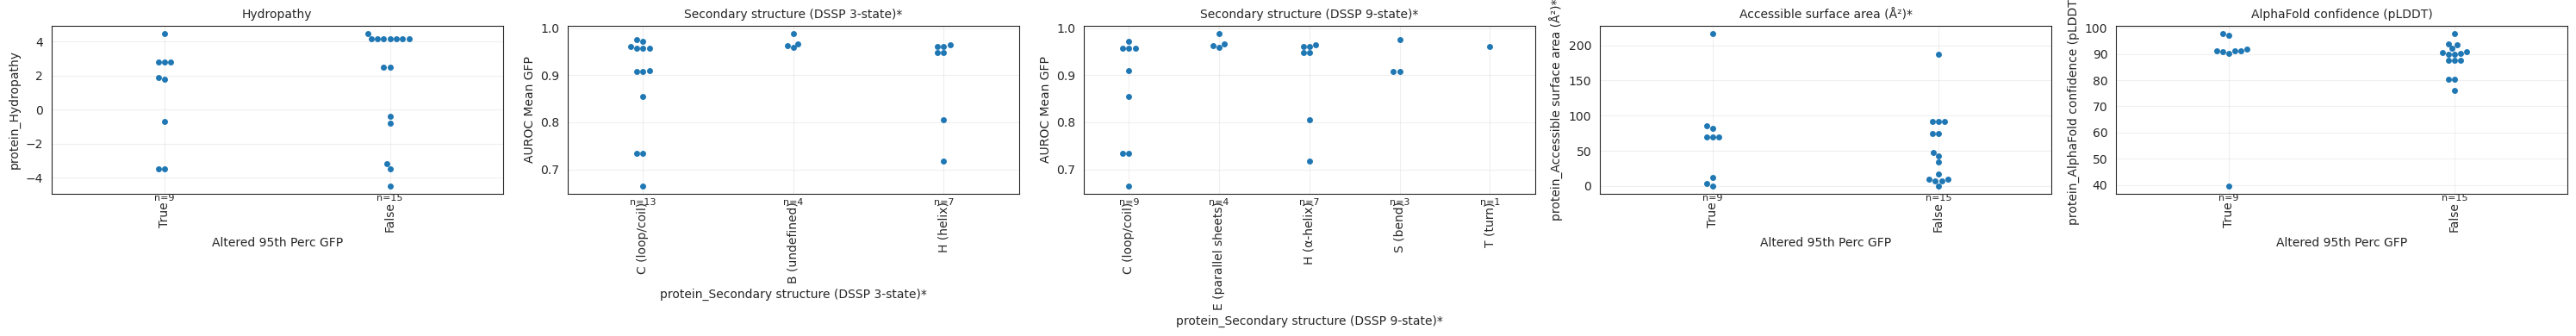

In [96]:
# Define feature categories for subcellular localization analysis
feature_categories = {
    'Signal_Sequences_Targeting': [
        'protein_Signal (UniProt)',
        'protein_Transit peptide (UniProt)', 
        'protein_Transmembrane (UniProt)',
        'protein_Topological domain (UniProt)',
        'protein_Intramembrane (UniProt)'
    ],
    
    'Nuclear_Targeting': [
        'protein_Motif (UniProt)',
        'protein_Region (UniProt)'
    ],
    
    'Structural_Context': [
        'protein_Hydropathy',
        'protein_Secondary structure (DSSP 3-state)*',
        'protein_Secondary structure (DSSP 9-state)*',
        'protein_Accessible surface area (Å²)*',
        'protein_AlphaFold confidence (pLDDT)'
    ],
    
    'Post_Translational_Modifications': [
        'protein_Lipidation (UniProt)',
        'protein_Glycosylation (UniProt)',
        'protein_Modified residue (UniProt)',
        'protein_Acetylation',
        'protein_Phosphorylation',
        'protein_Ubiquitination'
    ],
    
    'Protein_Domains_Sites': [
        'protein_Domain (UniProt)',
        'protein_Active site (UniProt)',
        'protein_Binding site (UniProt)',
        'protein_Coiled coil (UniProt)',
        'protein_Zinc finger (UniProt)'
    ]
}

def determine_feature_type(df, feature):
    """Determine if feature is categorical or continuous"""
    if feature not in df.columns:
        return None
    
    # Get non-null values
    values = df[feature].dropna()
    if len(values) == 0:
        return None
    
    # Check if numeric
    if pd.api.types.is_numeric_dtype(values):
        return 'continuous'
    else:
        return 'categorical'

def clean_categorical_data(series, max_categories=15):
    """Clean categorical data for plotting"""
    # Remove null values
    cleaned = series.dropna()
    
    # Get value counts
    value_counts = cleaned.value_counts()
    
    # If too many categories, keep top N
    if len(value_counts) > max_categories:
        top_categories = value_counts.head(max_categories).index
        cleaned = cleaned[cleaned.isin(top_categories)]
    
    return cleaned


def format_long_string(text, max_chars=50):
    """Format long strings with line breaks at word boundaries"""
    if len(str(text)) <= max_chars:
        return str(text)
    
    words = str(text).split()
    lines = []
    current_line = ""
    
    for word in words:
        if len(current_line) == 0:
            current_line = word
        elif len(current_line) + len(word) + 1 <= max_chars:
            current_line += " " + word
        else:
            lines.append(current_line)
            current_line = word
    
    if current_line:
        lines.append(current_line)
    
    return "\n".join(lines)

df = rad51d_allele.to_pandas()
figsize_per_plot=(6, 4) 

fig, axes = plt.subplots(1, 5, figsize=(figsize_per_plot[0] * 5, figsize_per_plot[1] * 1))
for i, feature in enumerate(feature_categories["Structural_Context"]):
    ax = axes[i]
    
    # Determine feature type
    feature_type = determine_feature_type(df, feature)
    
    if feature_type is None:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(feature.replace('protein_', '').replace(' (UniProt)', ''), fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    if feature_type == 'categorical':
        # For categorical features: boxenplot of AUROC_Mean_GFP per category
        plot_data = df[[feature, 'AUROC_Mean_GFP']].dropna()
        if len(plot_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Clean categorical data
            cleaned_feature = clean_categorical_data(plot_data[feature])
            plot_data_clean = plot_data[plot_data[feature].isin(cleaned_feature)]
            if len(plot_data_clean) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                # Format long category labels
                plot_data_clean = plot_data_clean.copy()
                plot_data_clean[feature] = plot_data_clean[feature].apply(format_long_string)
                
                sns.swarmplot(data=plot_data_clean, x=feature, y='AUROC_Mean_GFP', ax=ax)
                ax.tick_params(axis='x', rotation=90, labelsize=10)
                ax.set_ylabel('AUROC Mean GFP')
                
                # Add sample sizes - get actual x-tick labels and positions
                x_labels = [tick.get_text() for tick in ax.get_xticklabels()]
                cat_counts = plot_data_clean[feature].value_counts()
                for j, label in enumerate(x_labels):
                    count = cat_counts.get(label, 0)
                    ax.text(j, ax.get_ylim()[0]-0.01, f'n={count}', ha='center', va='top', fontsize=8)
    
    else:  # continuous
        # For continuous features: boxenplot per Altered_95th_perc_both_batches_GFP category
        plot_data = df[[feature, 'Altered_95th_perc_both_batches_GFP']].dropna()
        
        if len(plot_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Format long category labels
            plot_data = plot_data.copy()
            plot_data['Altered_95th_perc_both_batches_GFP'] = plot_data['Altered_95th_perc_both_batches_GFP'].apply(format_long_string)
            
            sns.swarmplot(data=plot_data, x='Altered_95th_perc_both_batches_GFP', y=feature, ax=ax)
            ax.set_xlabel('Altered 95th Perc GFP')
            ax.tick_params(axis='x', rotation=90, labelsize=10)
            
            # Add sample sizes - get actual x-tick labels and positions
            x_labels = [tick.get_text() for tick in ax.get_xticklabels()]
            cat_counts = plot_data['Altered_95th_perc_both_batches_GFP'].value_counts()
            for j, label in enumerate(x_labels):
                count = cat_counts.get(label, 0)
                ax.text(j, ax.get_ylim()[0]-0.01, f'n={count}', ha='center', va='top', fontsize=8)
    
    ax.set_title(feature.replace('protein_', '').replace(' (UniProt)', ''), fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [92]:
rad51d_allele.filter(
    pl.col('protein_Secondary structure (DSSP 9-state)*').str.contains("para")
)

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_prot_abun_t_stat,U2OS_prot_abun_t_pval,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP,Gene_right,U2OS_cc_t_stat_right,U2OS_cc_t_pval_right,U2OS_prot_abun_t_stat_right,U2OS_prot_abun_t_pval_right,…,Family History LR_PMID:31131967,Case-Control LR_PMID:31131967,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo
str,str,f64,f64,f64,f64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""RAD51D""","""RAD51D_Met308Val""",-1.519151,0.172522,14.967472,0.000001,"""2025_01_Batch_13-14""",true,true,true,true,false,true,false,false,false,false,0.989016,0.875648,0.981328,0.965096,0.917278,0.874017,0.951975,0.97468,0.81967,0.990394,0.960539,0.978217,0.987976,0.931626,0.987638,"""RAD51D""",-1.519151,0.172522,14.967472,0.000001,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RAD51D""","""RAD51D_Glu307Lys""",-3.404294,0.011376,0.849752,0.42357,"""2025_01_Batch_13-14""",false,true,true,true,true,false,true,false,false,false,0.967229,0.930122,0.979505,0.964171,0.962289,0.994705,0.95904,0.976579,0.98191,0.950231,0.929873,0.969301,0.982431,0.878334,0.984226,"""RAD51D""",-3.404294,0.011376,0.849752,0.42357,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RAD51D""","""RAD51D_Ile251Val""",0.777641,0.462249,4.733465,0.002124,"""2025_01_Batch_13-14""",false,false,false,true,false,false,false,false,false,false,0.958971,0.840534,0.951886,0.95844,0.901484,0.999522,0.953403,0.942729,0.999525,0.931935,0.803446,0.963478,0.961044,0.681542,0.986006,"""RAD51D""",0.777641,0.462249,4.733465,0.002124,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RAD51D""","""RAD51D_Val132Ile""",1.195183,0.270932,11.40

In [100]:
[x.replace("_", "-") for x in rad51d_allele.unique("gene_allele")["gene_allele"].to_numpy()]

['RAD51D-Glu233Gly',
 'RAD51D-Ala231Ser',
 'RAD51D-Glu307Lys',
 'RAD51D-Ile251Val',
 'RAD51D-Val132Ile',
 'RAD51D-Arg55Trp',
 'RAD51D-Cys9Ser',
 'RAD51D-Val66Met',
 'RAD51D-His23Arg',
 'RAD51D-Gly289Ser',
 'RAD51D-Phe305Leu',
 'RAD51D-Asn138His',
 'RAD51D-Thr328Ile',
 'RAD51D-Val28Leu',
 'RAD51D-Ser46Cys',
 'RAD51D-Met308Val',
 'RAD51D-Val66Leu',
 'RAD51D-Ile17Val',
 'RAD51D-Val56Gly']

In [97]:
# rad51d_allele.group_by('protein_Secondary structure (DSSP 9-state)*').agg(pl.len())

gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_Morph,Altered_95th_perc_Morph
str,str,str,str,str,f64,f64
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.881766,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.927047,1.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.955578,1.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.620069,0.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.940271,1.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.930671,1.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.967725,1.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_AGP,Altered_95th_perc_AGP
str,str,str,str,str,f64,f64
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.663015,0.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.930422,0.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.918189,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.901028,0.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.928097,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.903605,0.0
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.865099,0.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_GFP,Altered_95th_perc_GFP
str,str,str,str,str,f64,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.872209,0.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.919332,0.0
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.86021,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.899079,0.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.685848,0.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.9335,0.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.921312,0.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_Mito,Altered_95th_perc_Mito
str,str,str,str,str,f64,f64
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.928145,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.940053,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.919005,0.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.681612,0.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.969432,1.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.967036,1.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.956083,0.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_DNA,Altered_95th_perc_DNA
str,str,str,str,str,f64,f64
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.887589,1.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.851588,0.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.497403,0.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.857109,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.866001,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.886519,1.0
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.733135,0.0


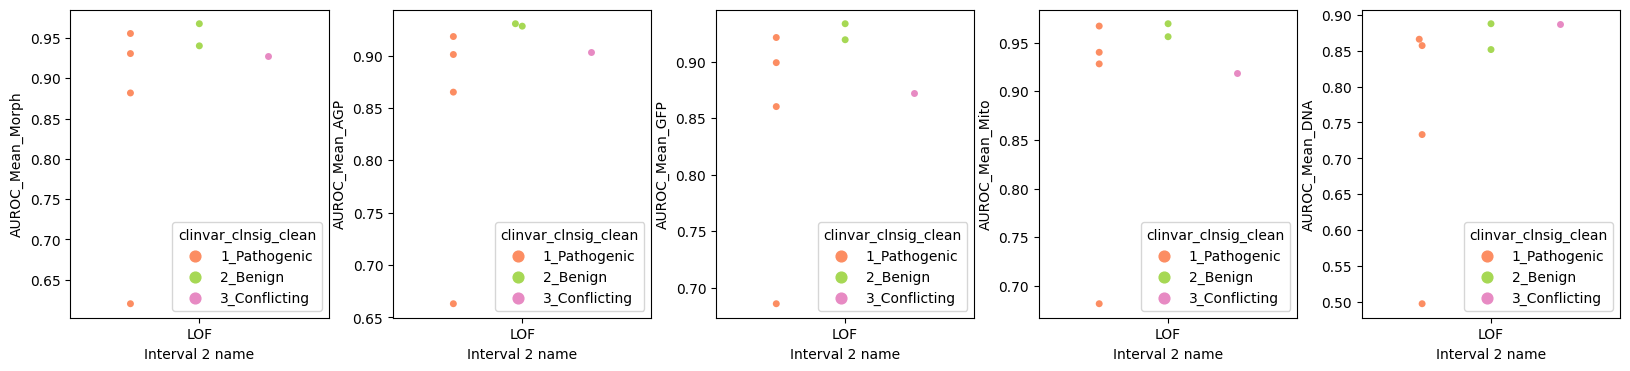

In [81]:
func_scores = imaging_summary.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for x, col in enumerate(auroc_cols):
    for i in range(1,7):
        if i != 2:
            continue
        int_name = f"Interval {i} name"
        mavedb_name = f"Interval {i} MaveDB class"
        func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
        if func_mave.shape[0] > 0:
            # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
            # fig, ax = plt.subplots(1,2,figsize=(15,6))
            hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
            sns.swarmplot(
                data=func_mave.unique(subset="gene_variant").to_pandas(),
                x=int_name,
                y=col,
                ax=axes.flatten()[x],
                palette=palette_dict["clinvar_clnsig_clean"], 
                hue="clinvar_clnsig_clean", 
                hue_order=hue_order,
                dodge="auto",
                # width=.6,
            )
            display(func_mave.unique(subset="gene_variant").select(
                ["gene_variant", "gene_variant_pp","clinvar_clnsig_clean", int_name, mavedb_name, col, alter_95th_cols[x]]
            ))
            # axes.flatten()[i-1].axhline(func_mave["dualipa_threshold"].to_numpy()[0], color="tomato", linestyle="--")
            # sns.boxenplot(
            #     data=func_mave.unique(subset="gene_variant").to_pandas(),
            #     x=mavedb_name,
            #     y="zscore_log2",
            #     ax=ax[1],
            #     palette=palette_dict["clinvar_clnsig_clean"],
            #     hue="clinvar_clnsig_clean", 
            #     hue_order=hue_order,
            #     dodge=True
            # )
        # else:
        #     fig.delaxes(axes.flatten()[i-1])

    # fig.delaxes(axes.flatten()[6])
    # fig.delaxes(axes.flatten()[7])
    plt.subplots_adjust(wspace=0.25)
    
plt.show()

In [56]:
# norm_feat_gene = pl.read_parquet("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_var_cp_profiles_oneperc_int_featselect.parquet")